In [1]:
import time
import torch
import triton
import triton.language as tl
import numpy as np
import math
from datetime import datetime
import pandas as pd

 # DNA: ACGT -> so we have to generate out of 4 random alphbets 

In [2]:
def generate_random_sequences(batch_size, seq_len): 
    torch.manual_seed(42)
    seq1 = torch.randint(0, 4, (batch_size, seq_len), device='cuda')
    seq2 = torch.randint(0, 4, (batch_size, seq_len), device='cuda')
    return seq1, seq2

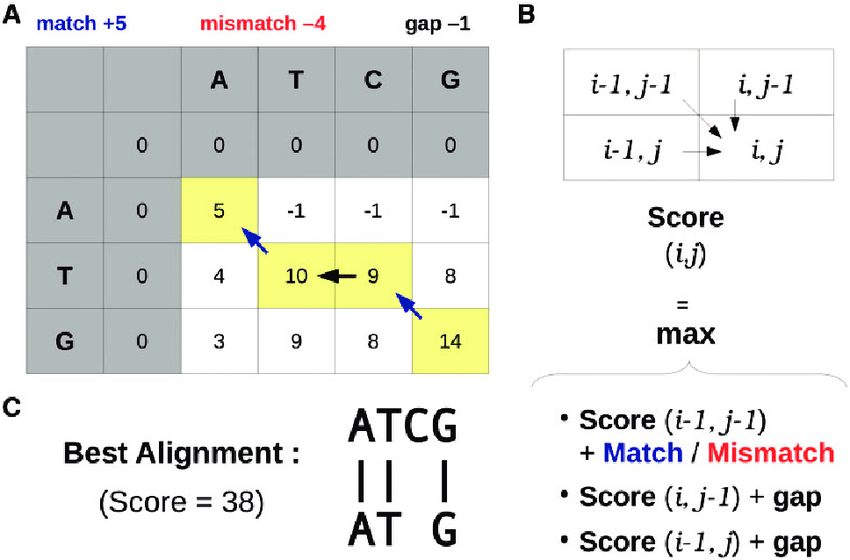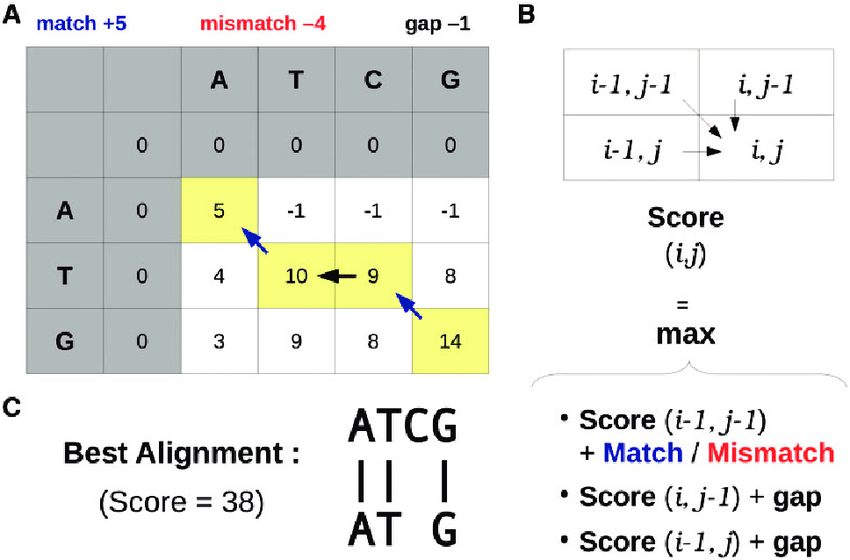

# Pytorch

Formula

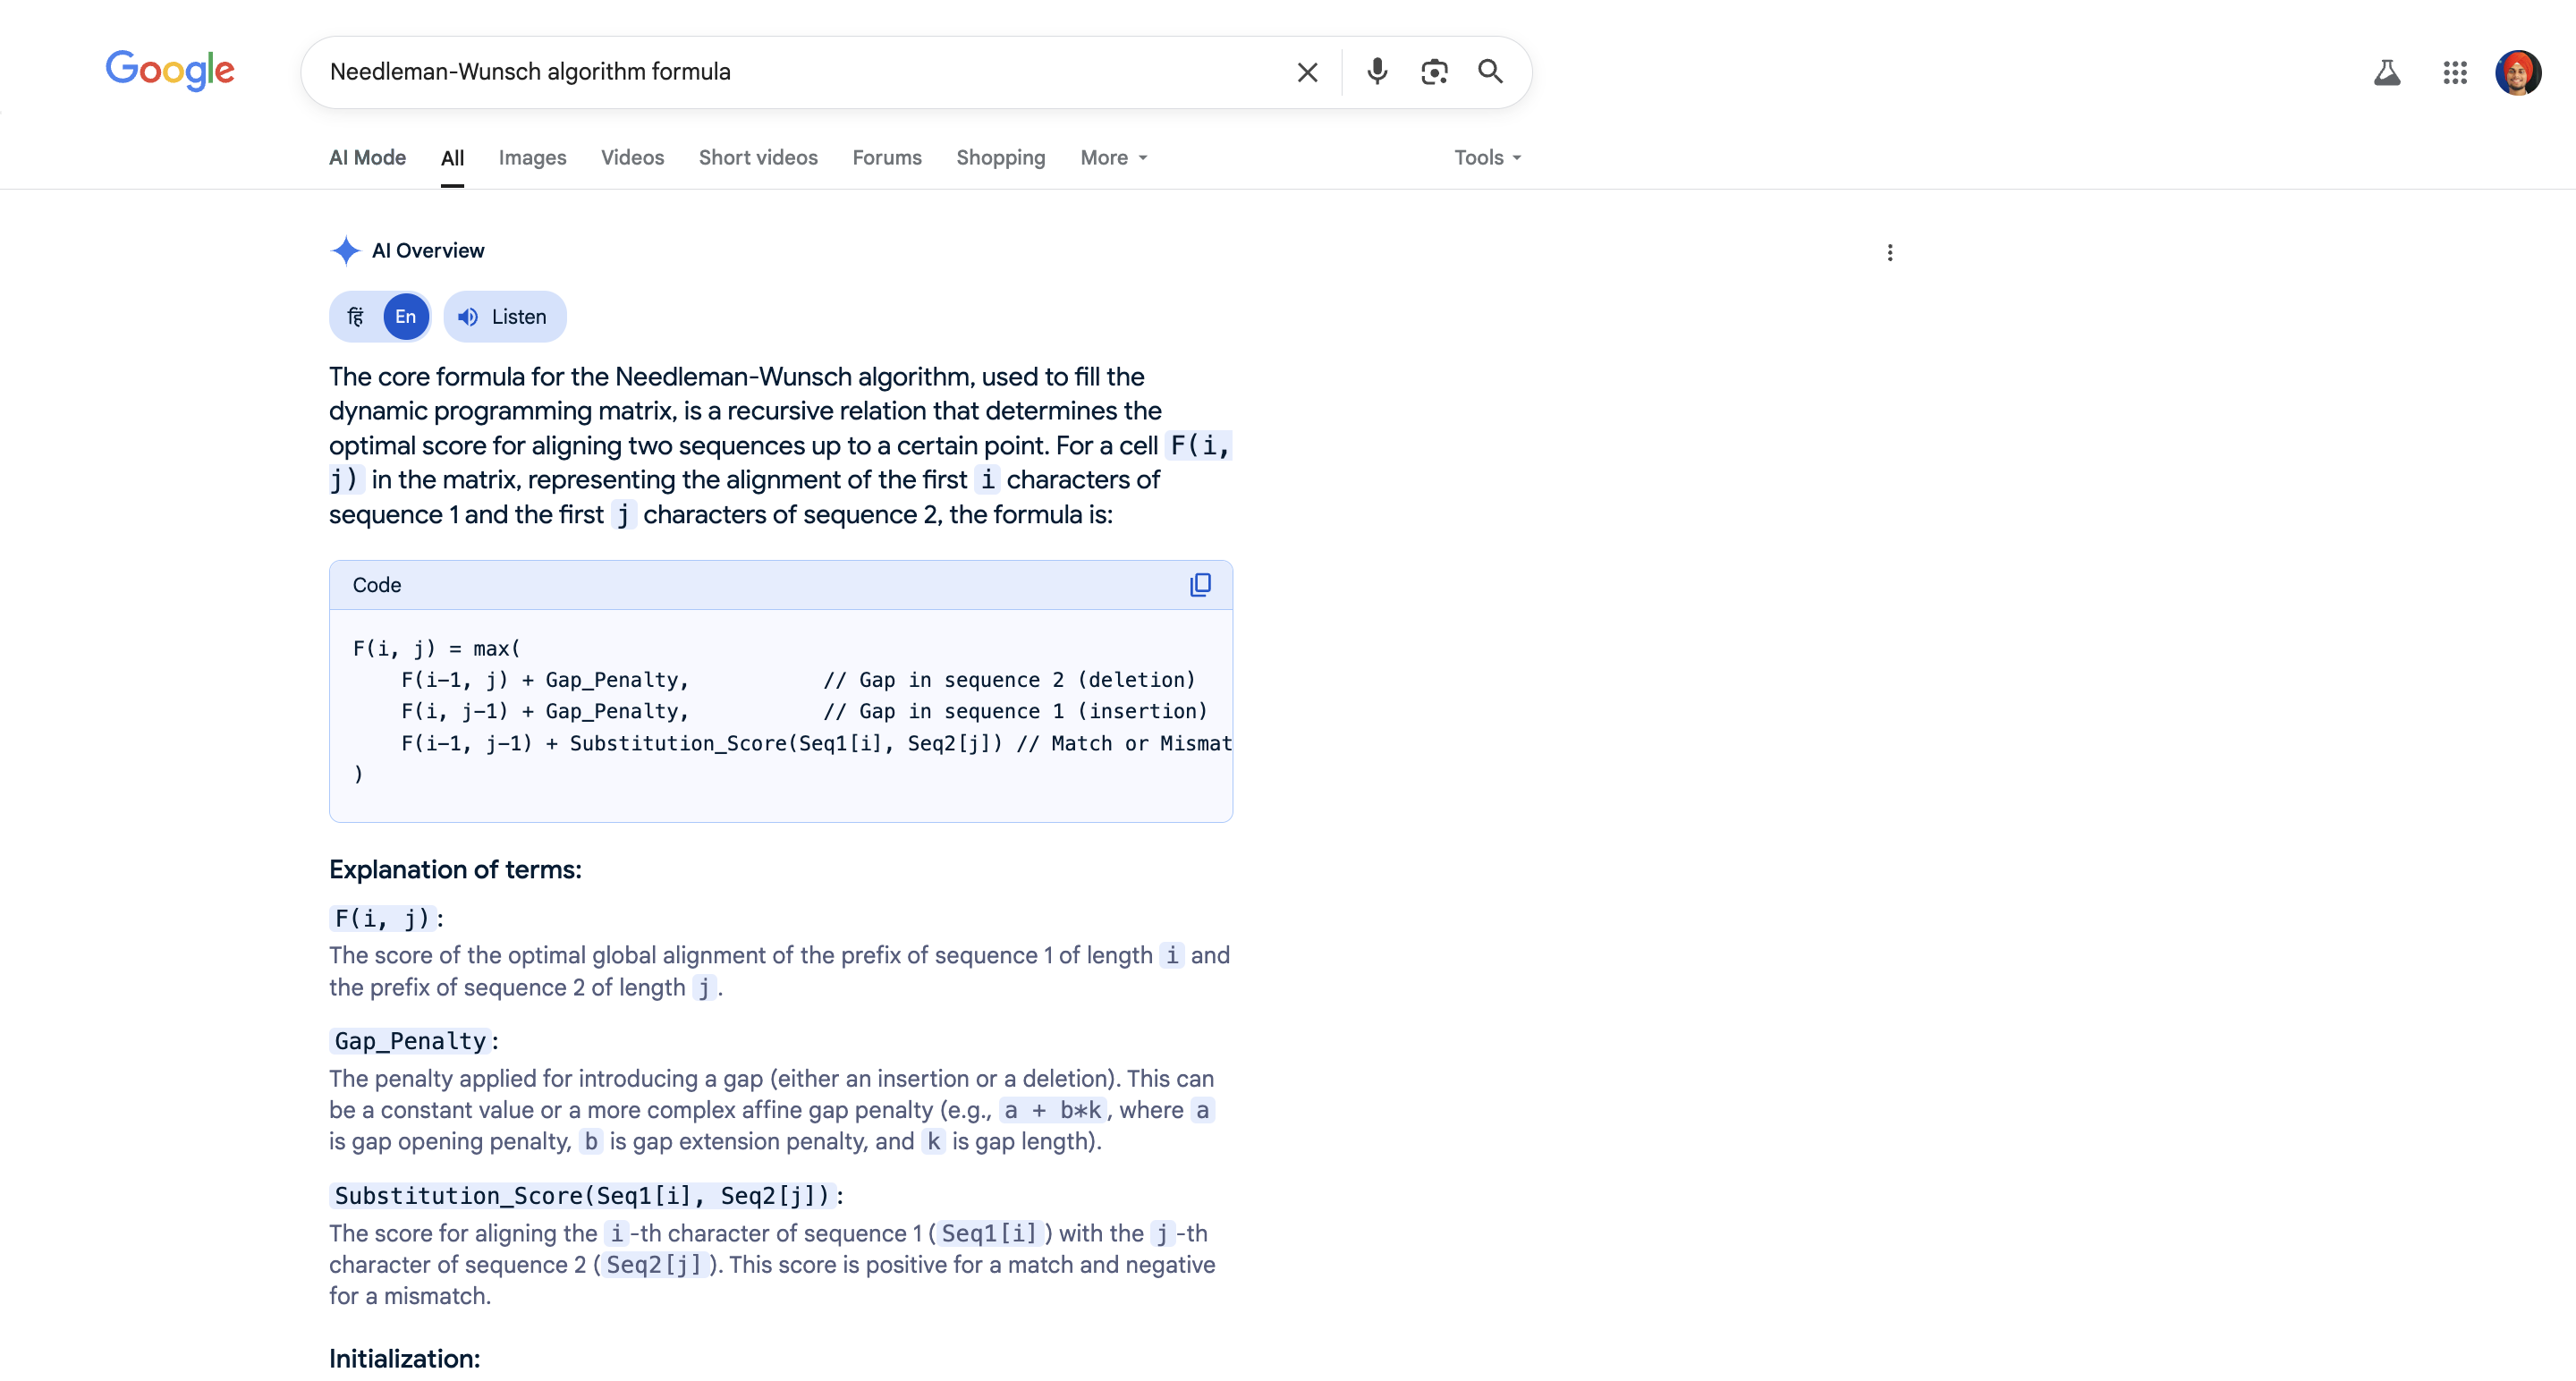

In [3]:
def needleman_wunsch_pytorch(seq1, seq2, match=1, mismatch=-1, gap=-2):
    batch_size, M = seq1.shape
    N = seq2.shape[1] 
    dp = torch.zeros((batch_size, M + 1, N + 1), device='cuda')
    dp[:, 0, :] = torch.arange(0, -(N+1)*gap, -gap).repeat(batch_size, 1)
    dp[:, :, 0] = torch.arange(0, -(M+1)*gap, -gap).unsqueeze(0).repeat(batch_size, 1)
    
    for i in range(1, M + 1):
        for j in range(1, N + 1):
            match_score = (seq1[:, i-1] == seq2[:, j-1]).float() * match + (seq1[:, i-1] != seq2[:, j-1]).float() * mismatch
            dp[:, i, j] = torch.max(torch.stack([ dp[:, i-1, j-1] + match_score, dp[:, i-1, j] + gap,dp[:, i, j-1] + gap], dim=1), dim=1)[0]
    
    return dp[:, M, N]

# Triton

In [4]:
@triton.jit
def needleman_wunsch_triton_kernel(seq1_ptr, seq2_ptr, dp_ptr, output_ptr, M, N,match: tl.constexpr, mismatch: tl.constexpr, gap: tl.constexpr
):
    pid = tl.program_id(0)
    
    seq1_off = pid * M
    seq2_off = pid * N
    dp_off = pid * (M + 1) * (N + 1)
    
    for j in range(N + 1):
        tl.store(dp_ptr + dp_off + j, -j * gap)
    for i in range(1, M + 1):
        tl.store(dp_ptr + dp_off + i * (N + 1), -i * gap)
    
    for i in range(1, M + 1):
        for j in range(1, N + 1):
            s1 = tl.load(seq1_ptr + seq1_off + (i - 1))
            s2 = tl.load(seq2_ptr + seq2_off + (j - 1))
            
            match_score = tl.where(s1 == s2, match, mismatch)
            
            diag_score = tl.load(dp_ptr + dp_off + (i-1) * (N+1) + (j-1)) + match_score
            up_score = tl.load(dp_ptr + dp_off + (i-1) * (N+1) + j) + gap
            left_score = tl.load(dp_ptr + dp_off + i * (N+1) + (j-1)) + gap
            
            max_score = tl.maximum(diag_score, tl.maximum(up_score, left_score))
            tl.store(dp_ptr + dp_off + i * (N+1) + j, max_score)
    
    final_score = tl.load(dp_ptr + dp_off + M * (N+1) + N)
    tl.store(output_ptr + pid, final_score)


In [5]:
def needleman_wunsch_triton(seq1, seq2, match=1, mismatch=-1, gap=-2):
    batch_size, M = seq1.shape
    N = seq2.shape[1]
  
    dp = torch.zeros((batch_size, (M+1) * (N+1)), device='cuda', dtype=torch.float32)
    output = torch.empty(batch_size, device='cuda', dtype=torch.float32)
    needleman_wunsch_triton_kernel[(batch_size,)](
        seq1, seq2, dp, output,
        M, N, match, mismatch, gap
    )
    
    return output


# Test case to verify answer are correct 

Earlier, test case were failing  because of bug in triton dp eqution

In [11]:
def verify_testcase(batch_size, seq_len):
    seq1, seq2 = generate_random_sequences(batch_size, seq_len)
    pytorch_result = needleman_wunsch_pytorch(seq1, seq2).cpu().numpy()
    triton_result = needleman_wunsch_triton(seq1, seq2).cpu().numpy()
    pytorch_triton_match = np.allclose(pytorch_result, triton_result, rtol=1e-5)
    print("PyTorch vs Triton:", "PASS" if pytorch_triton_match else "FAIL")
    return pytorch_triton_match

In [12]:
verify_testcase(32, 16)
verify_testcase(64, 32)
verify_testcase(128, 64)
verify_testcase(256, 96)
verify_testcase(512, 128)

PyTorch vs Triton: PASS
PyTorch vs Triton: PASS
PyTorch vs Triton: PASS
PyTorch vs Triton: PASS
PyTorch vs Triton: PASS


True

In [7]:
def benchmarks(batch_size, seq_len, testcase_name, num_runs, warmup):
    seq1, seq2 = generate_random_sequences(batch_size, seq_len)
    
    torch.cuda.synchronize()
    pytorch_times = []
    for _ in range(warmup + num_runs):
        torch.cuda.synchronize()
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        
        start.record()
        _ = needleman_wunsch_pytorch(seq1, seq2)
        end.record()
        
        torch.cuda.synchronize()
        pytorch_times.append(start.elapsed_time(end) / 1000.0)
    
    pytorch_time = np.mean(pytorch_times[warmup:])
    
    torch.cuda.synchronize()
    triton_times = []
    for _ in range(warmup + num_runs):
        torch.cuda.synchronize()
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        
        start.record()
        _ = needleman_wunsch_triton(seq1, seq2)
        end.record()
        
        torch.cuda.synchronize()
        triton_times.append(start.elapsed_time(end) / 1000.0)
    
    triton_time = np.mean(triton_times[warmup:])
    speedup = pytorch_time / triton_time
    
    return {'testcase_name': testcase_name,'batch_size': batch_size,'seqlen': seq_len,'pytorch_time': pytorch_time,'triton_time': triton_time,'speedup': speedup
    }


In [8]:
def benchmark_run():
    test_cases = [
        (32, 32, "Extra Small"),
        (64, 48, "Small"),
        (128, 64, "Small-Medium"),
        (256, 96, "Medium"),
        (512, 128, "Medium-Large"),
        (1024, 128, "Large"),
        (2048, 192, "Extra Large"),
        (4096, 256, "Huge"),
        (1024, 512, "Long Sequences"),
    ]
    
    print("testcase_name,batch_size,seqlen,pytorch_time,triton_time,speedup")
    
    for batch_size, seq_len, namee in test_cases:
        result = benchmarks(batch_size, seq_len, namee,num_runs=10, warmup=3)
        print(f"{result['testcase_name']},{result['batch_size']},{result['seqlen']},{result['pytorch_time']:.6f},{result['triton_time']:.6f},{result['speedup']:.2f}")

In [9]:
benchmark_run()

testcase_name,batch_size,seqlen,pytorch_time,triton_time,speedup
Extra Small,32,32,0.221362,0.000355,623.12
Small,64,48,0.490146,0.000687,713.80
Small-Medium,128,64,0.876073,0.001299,674.62
Medium,256,96,1.985040,0.004690,423.26
Medium-Large,512,128,3.539436,0.015211,232.68
Large,1024,128,3.534377,0.030219,116.96
Extra Large,2048,192,7.969571,0.135129,58.98
Huge,4096,256,14.309245,0.475797,30.07
Long Sequences,1024,512,57.278904,0.499893,114.58
